### Librerias

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'

In [55]:
from pandas import read_csv, merge, concat
from geopandas import read_file, sjoin_nearest, GeoDataFrame, points_from_xy

#import h3pandas

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from numpy import array as np_array
from numpy.linalg import norm as np_norm

from tqdm import tqdm

from zipfile import ZipFile

import matplotlib.pyplot as plt

### Carga de datos

In [3]:
with ZipFile("data/mza_09_cpv2020.zip") as z: # Datos censales a nivel manzana CDMX
    censo = read_csv(z.open("mza_09_cpv2020.csv"), 
                        dtype={"ENTIDAD":str,"MUN":str,"LOC":str,"AGEB":str,"MZA":str},
                        na_values=['*','N/D'],
                        #usecols=["ENTIDAD","MUN","LOC","NOM_LOC","AGEB","MZA","POBTOT"]
                        )

censo = censo[~censo.NOM_LOC.str.contains('Total')].reset_index(drop=True)
censo['CVEGEO'] = censo.ENTIDAD + censo.MUN + censo.LOC + censo.AGEB + censo.MZA

# PreProcesamos variables "relativas" en el censo
censo["wGRAPROES"]=censo["POBTOT"]*censo["GRAPROES"]
censo["wGRAPROES_F"]=censo["POBFEM"]*censo["GRAPROES_F"]
censo["wGRAPROES_M"]=censo["POBMAS"]*censo["GRAPROES_M"]

censo["wPROM_OCUP"]=censo["VIVTOT"]*censo["PROM_OCUP"]
censo["wPRO_OCUP_C"]=censo["VIVTOT"]*censo["PRO_OCUP_C"]  

In [4]:
cols = read_file('zip://data/colonias_seduvi.zip') # Colonias CDMX

man = read_file('zip://data/manzanas_09.zip/09m.shp', dtype={'CVEGEO':str}).to_crs(cols.crs) # Manzanas CDMX
cas = read_file('zip://data/caserios_09.zip/09cd.shp', dtype={'CVEGEO':str}).to_crs(cols.crs) # Caserio disperso CDMX

### Geoproceso para integrar los datos espaciales

In [5]:
# Calculamos un punto repcols_pobentativo de la manzana (puede ser el centroide u otro siempre y cuando este dentro del poligono)
cas['geometry'] = cas.representative_point()
man['geometry'] = man.representative_point() 

man = concat([man, cas], ignore_index=True)

cols_man = sjoin_nearest(cols, man, distance_col='dist', how="right") #join espacial!

### Join tabular 

In [6]:
cols_pob = merge(cols_man[['cve_col','colonia','CVEGEO','geometry']],censo, on='CVEGEO') # Unimos datos tabulares y espaciales


cols_pob = cols_pob.groupby(['cve_col','colonia']).sum(numeric_only=True).reset_index() # Agrupamos por colonia y sumamos


# Procesamos variables "relativas" en el censo
cols_pob["GRAPROES"]=cols_pob["wGRAPROES"]/cols_pob["POBTOT"]
cols_pob["GRAPROES_F"]=cols_pob["wGRAPROES_F"]/cols_pob["POBFEM"]
cols_pob["GRAPROES_M"]=cols_pob["wGRAPROES_M"]/cols_pob["POBMAS"]

cols_pob["PROM_OCUP"]=cols_pob["wPROM_OCUP"]/cols_pob["VIVTOT"]
cols_pob["PRO_OCUP_C"]=cols_pob["wPRO_OCUP_C"]/cols_pob["VIVTOT"]

In [7]:
cols_f = merge(cols, cols_pob, on=['cve_col','colonia']).iloc[:,:-5] # Base final

In [8]:
cols = cols_f.copy() # Usamos una copia para procesar

In [9]:
del cols_pob, cols_man, censo, man, cas # Liberamos memoria

### Estadarzación de variables por media y desviación

Se estandariza cada una de las variables a lo largo de todas las muestras (verticalmente)

In [10]:
for i in tqdm(cols.columns[8:]):
    cols[i] = StandardScaler().fit_transform(np_array(cols[i]).reshape(-1,1)).reshape(len(cols[i]),) 

100%|██████████| 222/222 [00:00<00:00, 818.96it/s]


### Normalización de variables a módulo 1

Se normaliza el conjunto de variables por muestra (horizontalmente)

In [11]:
for i in tqdm(range(len(cols))):
    cols.loc[i,'POBTOT':'VPH_SINTIC'] = np_array(cols.loc[i,'POBTOT':'VPH_SINTIC'])/np_norm(np_array(cols.loc[i,'POBTOT':'VPH_SINTIC'])) 

100%|██████████| 1801/1801 [00:22<00:00, 80.06it/s]


### Justificación
Con lo anterior se busca generar un _embedding_ para cada muestra que resulte comparable en escala entre componentes (horizontalmente) y muestras (verticalmente).

En particular, a cada colonia de la CDMX se le calculó un _embedding_ corresponde a un vector de 222 dimensiones correspondientes a las variables censales 

In [12]:
cols.sample(5) # Veamos que todos los valores corresponden a un mismo orden de magnitud

,cve_ent,alcaldia,cve_col,colonia,pob_2010,area,perimetro,geometry,POBTOT,POBFEM,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
420,09,CUAJIMALPA DE MORELOS,04-001,ABDIAS GARCIA SOTO,1770.0,256183.011,2141.689,"POLYGON ((468928.918 2139468.208, 468957.406 2...",-0.079005,-0.078653,...,-0.078867,-0.080077,-0.073898,-0.059996,-0.044274,-0.047763,0.016118,-0.018672,-0.069742,-0.041104
1056,09,LA MAGDALENA CONTRERAS,08-033,LOS PADRES,6976.0,252733.317,3566.866,"POLYGON ((473577.489 2136091.320, 473600.296 2...",0.051328,0.053178,...,0.021147,0.026362,0.015521,0.012673,-0.027112,0.006032,-0.003524,0.010884,0.062728,-0.034063
1253,09,TLALPAN,12-036,EL ARENAL,1369.0,298819.270,2497.021,"POLYGON ((485348.930 2124021.766, 485562.566 2...",-0.073940,-0.074807,...,-0.081312,-0.075664,-0.077051,-0.075010,-0.072882,-0.075512,-0.037291,-0.029479,-0.048006,-0.029600
360,09,COYOACAN,03-151,MONTE DE PIEDAD,2193.0,154723.325,1718.709,"POLYGON ((482033.708 2139054.143, 482027.670 2...",-0.071191,-0.068432,...,-0.046926,-0.059898,-0.049482,-0.034451,-0.028293,-0.053162,-0.066333,-0.068585,-0.074796,-0.031802
939,09,IZTAPALAPA,07-157,PASEOS DE CHURUBUSCO,9584.0,2511163.873,8094.901,"POLYGON ((491116.787 2143920.385, 491214.161 2...",0.074979,0.078147,...,0.119127,0.086525,0.104521,0.128229,0.102682,0.092907,-0.035730,-0.036943,-0.011748,-0.017130


## Aplicación de negocio: FANAFESA 

### Carga de las direcciones correspondientes a los clientes

In [13]:
direcc = read_csv('/home/raul/Desktop/entropia.ai/fanafesa_goldenrecord/W_OSC_DIRECCION_V_TMP.csv')
direcc = direcc.query('state=="CDMX"').query('estatus_id==1').reset_index(drop=True)

/tmp/ipykernel_337508/2245633173.py:1: DtypeWarning: Columns (23,26,27,32,36,43,47,50,51,52,53,57,60,62,63,64,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  direcc = read_csv('/home/raul/Desktop/entropia.ai/fanafesa_goldenrecord/W_OSC_DIRECCION_V_TMP.csv')


In [14]:
direcc = GeoDataFrame(direcc[['id']], geometry=points_from_xy(direcc.final_longitud, direcc.final_latitud), crs='epsg:4326').to_crs(cols.crs)
direcc['cnt'] = 1

### Clientes de FANAFESA en la CDMX

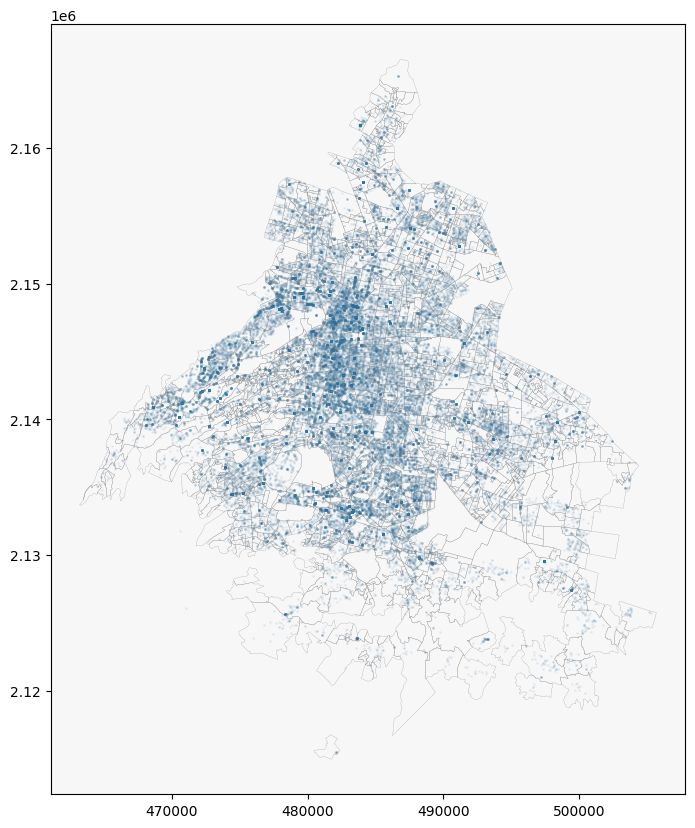

In [82]:
ax = cols.boundary.plot(linewidth=0.15, figsize=(15, 10), edgecolor='gray',)
direcc.plot(ax=ax, markersize=1, alpha=.07, color='#E74848', edgecolor='#1884B6')

ax.set_facecolor('#f7f7f7')

plt.savefig('mapa_1.png', dpi=300, bbox_inches='tight')


### Cálculo de clientes por cada 100 habitantes a nivel colonia

In [16]:
fana_cols = sjoin_nearest(cols[['cve_col','colonia','geometry']], direcc, distance_col='dist', how="right")
fana_cols = fana_cols.groupby(['cve_col','colonia']).cnt.sum().reset_index()

fana_cols = merge(cols_f[['cve_col','colonia','POBTOT', 'geometry']], fana_cols, on=['cve_col','colonia']).reset_index(drop=True)

fana_cols['clientes_index'] = 100*(fana_cols.cnt/fana_cols.POBTOT)

### Colonias con mayor cantidad de clientes relativo a su población total

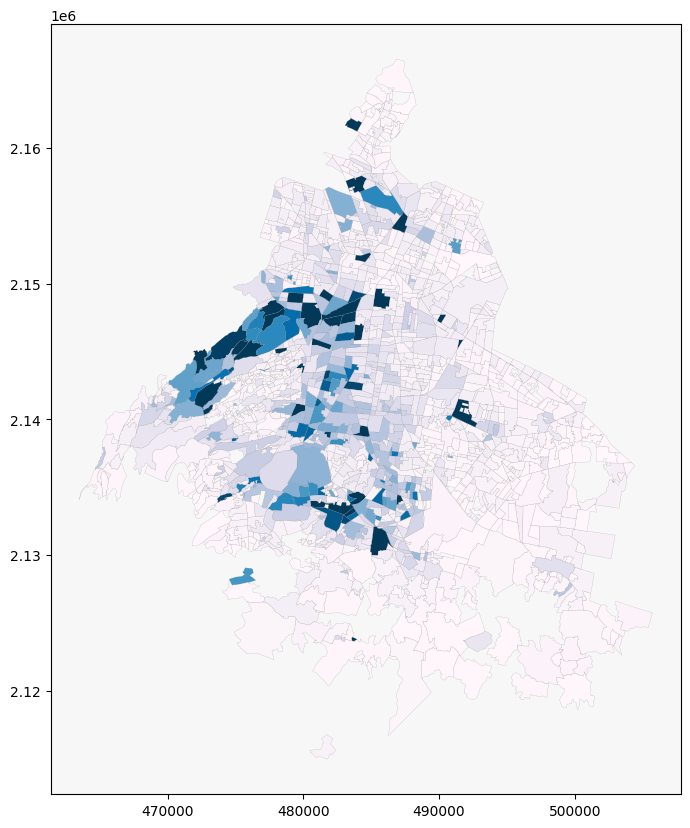

In [79]:
ax = fana_cols.plot(column='clientes_index',vmax=7, linewidth=0.1, edgecolor='gray',
                    figsize=(15, 10), cmap='PuBu')

ax.set_facecolor('#f7f7f7')

plt.savefig('mapa_2.png', dpi=300, bbox_inches='tight')


### Identificar las colonias con un mayor número de clientes, considerando aquellas que se encuentran por encima del cuantil 0.9 de la distribución
 Estas colonias se convierten en puntos de referencia, bajo la suposición de que comparten una o varias características socio-demográficas que influyen en la alta concentración de clientes observada.

In [18]:
cols_q = fana_cols.query(f'clientes_index>={round(fana_cols.clientes_index.quantile(.9), 2)}')
cols_q

,cve_col,colonia,POBTOT,geometry,cnt,clientes_index
26,02-036,INDUSTRIAL VALLEJO,1025,"POLYGON ((483529.053 2156463.469, 483590.426 2...",33,3.219512
63,02-076,SAN BERNABE (BARR),671,"POLYGON ((481879.844 2152622.856, 481873.331 2...",20,2.980626
98,14-001,ACACIAS,6376,"POLYGON ((481690.991 2141269.752, 481873.421 2...",190,2.979925
99,14-002,ACTIPAN,4380,"POLYGON ((481139.542 2141957.163, 481214.800 2...",111,2.534247
106,14-010,CREDITO CONSTRUCTOR,810,"POLYGON ((481327.579 2141264.613, 481351.520 2...",48,5.925926
...,...,...,...,...,...,...
1523,10-248,LOMAS DE SANTA FE II,3073,"POLYGON ((473940.828 2142774.256, 473949.868 2...",370,12.040351
1529,10-146,LOS CEDROS,908,"POLYGON ((474820.841 2141144.672, 474857.831 2...",24,2.643172
1539,10-170,PASEO DE LAS LOMAS-SAN GABRIEL,3915,"POLYGON ((474459.559 2143663.935, 474476.269 2...",204,5.210728
1559,10-192,SAN ANGEL,2257,"POLYGON ((480008.577 2139738.427, 480000.539 2...",124,5.494019


In [19]:
cols.loc[cols.cve_col.isin(cols_q.cve_col),'target'] = True
cols['target'] = cols.target.fillna(False)

### Colonias superiores al cuantil 0.9 sobre el número de clientes por cada 100 habitantes

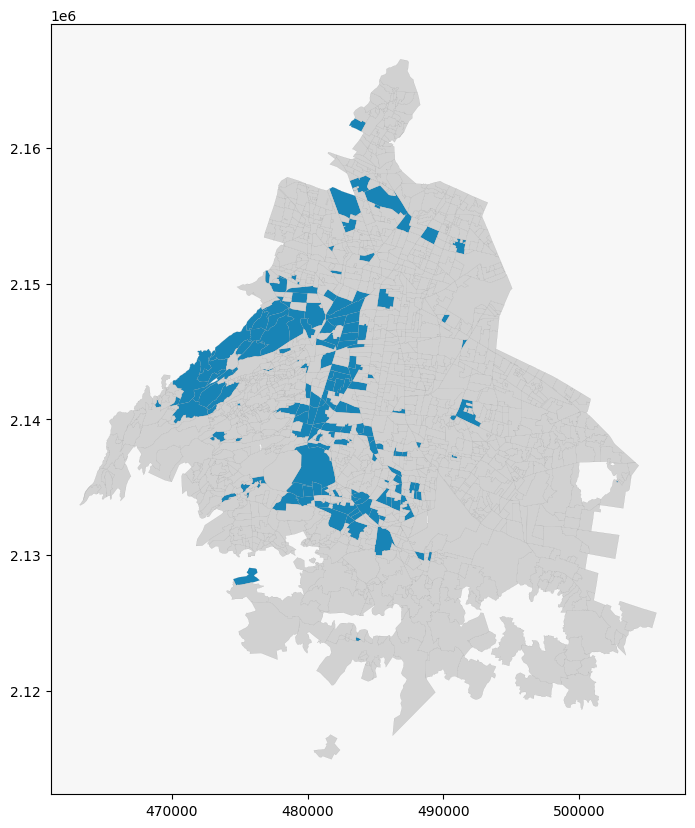

In [71]:
ax = cols[cols.target==True].plot(figsize=(15, 10), color='#1884B6', linewidth=0.07, edgecolor='gray')
cols[~(cols.target==True)].plot(ax=ax, color='#D1D1D1', linewidth=0.07, edgecolor='gray')

ax.set_facecolor('#f7f7f7')

plt.savefig('mapa_3.png', dpi=300, bbox_inches='tight')

### Cálculo del vector base
Una vez identificadas las colonias con un alto número de clientes, se calculó el vector base mediante el promedio de los respectivos embeddings asociados a dichas colonias. Este enfoque nos permite obtener un vector que, en cierta medida, concentra las características socio-demográficas de las colonias con una gran cantidad de clientes.

El cálculo del promedio de los embeddings es posible gracias a que se encuentran normalizados y estandarizados. Esta normalización y estandarización aseguran que todas las variables involucradas en los embeddings tengan la misma escala y sean comparables entre sí. Al operar con embeddings normalizados y estandarizados, evitamos sesgos debido a las diferencias en las magnitudes absolutas de las variables.

In [21]:
vector_base = np_array(cols[cols.target].loc[:,'POBTOT':'VPH_SINTIC'].mean())

### Cálculo de la similitud del vector base respecto al universo de colonias
A partir del coseno de similitud, se la comparación de otras colonias respecto al perfil promedio (vector base) para identificar áreas que se asemejan más o menos a las colonias de referencia y con ello explorar características particulares que podrían influir en la concentración de clientes en distintas localidades.

In [22]:
cols['cos_sim_fana'] = [(vector_base @ np_array(cols.loc[i:,'POBTOT':'VPH_SINTIC'])[0]) / (np_norm(vector_base)*np_norm(np_array(cols.loc[i:,'POBTOT':'VPH_SINTIC'])[0])) for i in range(len(cols))]

### Colonias de potencial interés debido a su similitud a partir de un umbral

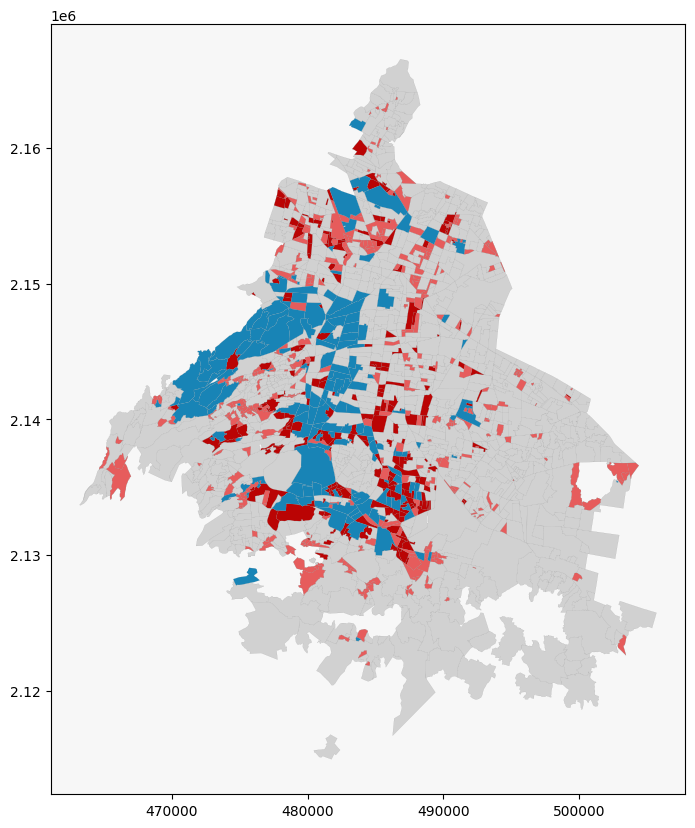

In [72]:
ax = cols[~(cols.target==True)].plot(color='#D1D1D1', figsize=(15, 10), linewidth=0.07, edgecolor='gray')
cols[(~cols.target) & (cols.cos_sim_fana>.8)].plot(ax=ax, color='#ba0404', linewidth=0.07, edgecolor='gray') ## Colonias muy parecidas (muy potenciales)
cols[(~cols.target) & (cols.cos_sim_fana<=.8) & (cols.cos_sim_fana>.6)].plot(ax=ax, color='#e65c5c', linewidth=0.07, edgecolor='gray') ## Colonias parecidas (potenciales)
cols[cols.target==True].plot(ax=ax, figsize=(15, 10), color='#1884B6', linewidth=0.07, edgecolor='gray') ## Colonias de referencia

ax.set_facecolor('#f7f7f7')

plt.savefig('mapa_4.png', dpi=300, bbox_inches='tight')

In [44]:
## Hacer PCA sobre las azuless